<a href="https://colab.research.google.com/github/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Activate GPU

1.   Runtime menu
2.   Change runtime type
3.   Hardware accelerator -> GPU

## Get Foolbox

#### Solution

In [1]:
!pip3 install foolbox==3.0.0b1
# !pip3 install git+https://github.com/bethgelab/foolbox.git

In [0]:
import foolbox as fb

## Get a model

Get a pertrained PyTorch or TensorFlow model, e.g. `torchvision.models.resnet18` or `tf.keras.applications.ResNet50`.

#### PyTorch

#### Solution

In [0]:
import torch
import torchvision

In [18]:
torch.__version__

'1.4.0'

In [4]:
torch.cuda.is_available()

True

In [5]:
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
model = model.eval()

#### TensorFlow

#### Solution

In [3]:
!pip3 install --upgrade tensorflow

  Using cached https://files.pythonhosted.org/packages/85/d4/c0cd1057b331bc38b65478302114194bd8e1b9c2bbc06e300935c0e93d90/tensorflow-2.1.0-cp36-cp36m-manylinux2010_x86_64.whl
     |████████████████████████████████| 450kB 8.7MB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.1.0'

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
model = tf.keras.applications.ResNet50(weights="imagenet")

In [0]:
model = tf.keras.applications.ResNet50V2(weights="imagenet")

In [38]:
model = tf.keras.applications.MobileNetV2(weights="imagenet")

14540800/14536120 [==============================] - 3s 0us/step


## Turn your PyTorch / TensorFlow model into a Foolbox model

Don't forget to specify the correct bounds and preprocessing!

#### PyTorch Solution

In [0]:
# PyTorch ResNet18
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)

#### TensorFlow Solution

In [0]:
# TensorFlow ResNet50
preprocessing = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])
bounds = (0, 255)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

In [0]:
# TensorFlow ResNet50V2
preprocessing = dict()
bounds = (-1, 1)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

In [0]:
# TensorFlow MobileNetV2
preprocessing = dict()
bounds = (-1, 1)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

## Transform bounds

In the following, we want to work with a model that has `(0, 1)` bounds. Use `fmodel.transform_bounds`.

#### Solution

In [0]:
fmodel = fmodel.transform_bounds((0, 1))

In [0]:
assert fmodel.bounds == (0, 1)

## Get some test images

Get a batch of 16 images and the corrresponding labels. You can use `foolbox.utils.samples` to get up to 20 images, but you can also you your own data loader.

#### Solution

In [0]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

## Check the accuracy of your model to make sure you specified the correct preprocessing

#### Solution

In [117]:
fb.utils.accuracy(fmodel, images, labels)

0.9375

In [118]:
type(images), images.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([16, 224, 224, 3]))

In [119]:
type(labels), labels.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([16]))

## Run LinfDeepFool

#### Solution

In [0]:
attack = fb.attacks.LinfDeepFoolAttack()

In [0]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [122]:
is_adv

<tf.Tensor: shape=(16,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True])>

## Use EagerPy tensors and rerun the attack

#### Solution

In [0]:
import eagerpy as ep

In [0]:
images = ep.astensor(images)
labels = ep.astensor(labels)

In [0]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [53]:
is_adv

TensorFlowTensor(<tf.Tensor: shape=(16,), dtype=bool, numpy=
                 array([ True,  True,  True,  True,  True,  True,  True,  True, False,
                         True,  True,  True,  True,  True,  True,  True])>)

In [54]:
is_adv.float32().mean().item()

0.9375

## Using the Misclassification criterion explicitly

#### Solution

In [0]:
criterion = fb.criteria.Misclassification(labels)

In [0]:
raw, clipped, is_adv = attack(fmodel, images, criterion, epsilons=0.03)

In [0]:
is_adv

## Run the attack using many epsilons

#### Solution

In [0]:
import numpy as np

In [0]:
epsilons = np.linspace(0.0, 0.005, num=20)

In [0]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

In [59]:
is_adv.shape

(20, 16)

In [60]:
is_adv.float32().mean(axis=-1)

TensorFlowTensor(<tf.Tensor: shape=(20,), dtype=float32, numpy=
                 array([0.0625, 0.0625, 0.125 , 0.3125, 0.375 , 0.375 , 0.4375, 0.4375,
                        0.4375, 0.5   , 0.5625, 0.625 , 0.625 , 0.6875, 0.75  , 0.75  ,
                        0.75  , 0.8125, 0.8125, 0.8125], dtype=float32)>)

In [0]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)

In [62]:
robust_accuracy

TensorFlowTensor(<tf.Tensor: shape=(20,), dtype=float32, numpy=
                 array([0.9375, 0.9375, 0.875 , 0.6875, 0.625 , 0.625 , 0.5625, 0.5625,
                        0.5625, 0.5   , 0.4375, 0.375 , 0.375 , 0.3125, 0.25  , 0.25  ,
                        0.25  , 0.1875, 0.1875, 0.1875], dtype=float32)>)

## Plot the robust accuracy as a function of epsilon

#### Solution

In [0]:
import matplotlib.pyplot as plt

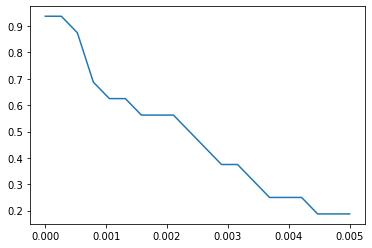

In [64]:
plt.plot(epsilons, robust_accuracy.numpy())

## Run a targeted attack

#### Solution

In [125]:
labels

TensorFlowTensor(<tf.Tensor: shape=(16,), dtype=int64, numpy=
                 array([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741,
                        471, 129,  99])>)

In [0]:
target_classes = (labels + 200) % 1000

In [127]:
target_classes

TensorFlowTensor(<tf.Tensor: shape=(16,), dtype=int64, numpy=
                 array([443, 759, 638, 190, 149,  53, 809, 809, 115, 655, 741, 830, 941,
                        671, 329, 299])>)

In [0]:
criterion = fb.criteria.TargetedMisclassification(target_classes)

In [0]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100)
# Note: 100 is too little -> results will be bad = perturbations will be relatively large (but 1000 takes much longer)

In [0]:
# epsilons = np.linspace(0.0, 10.0, num=20)
epsilons = None

In [0]:
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

In [141]:
is_adv

TensorFlowTensor(<tf.Tensor: shape=(16,), dtype=bool, numpy=
                 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
                         True,  True,  True,  True,  True,  True,  True])>)

In [142]:
fb.distances.l2(images, raw)

TensorFlowTensor(<tf.Tensor: shape=(16,), dtype=float32, numpy=
                 array([1.1608973 , 7.7231374 , 0.43456334, 6.1770263 , 1.0723019 ,
                        9.786309  , 1.0020152 , 1.1286135 , 5.781405  , 6.758443  ,
                        1.4110544 , 6.3083763 , 6.1295733 , 1.000447  , 2.0642292 ,
                        0.9876956 ], dtype=float32)>)

In [0]:
# attack_success_rate = is_adv.float32().mean(axis=-1)

In [0]:
# plt.plot(epsilons, attack_success_rate.numpy())

## Visualizing adversarial examples and perturbations

#### Solution

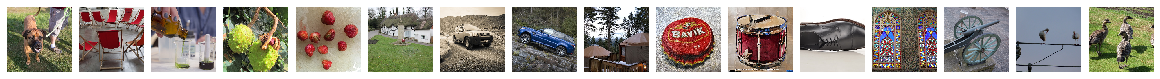

In [143]:
fb.plot.images(images)

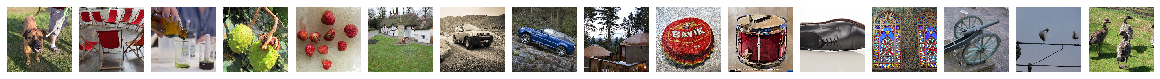

In [144]:
fb.plot.images(advs)

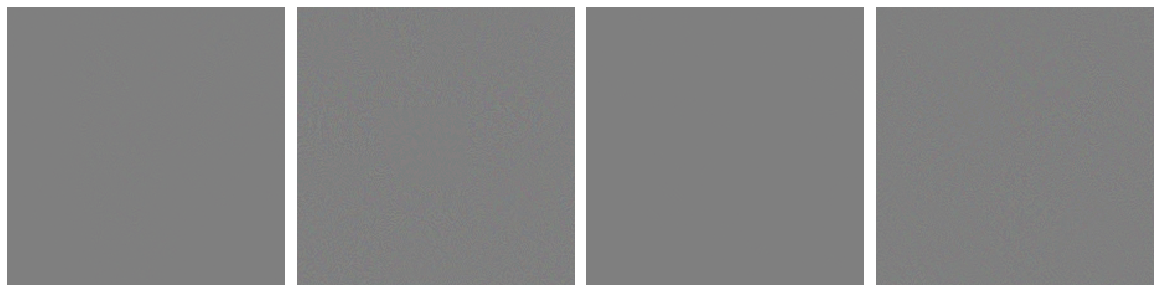

In [149]:
fb.plot.images(advs - images, n=4, bounds=(-1, 1), scale=4.)

## Continuing from here ...



*   Repeating an attack (`attack = attack.repeat(3)`)
*   Getting the per-sample worst-case over multiple attacks
    * stack attack results and take max over the attacks before taking the mean over samples
*   Gradient estimators (`fb.gradient_estimators.*`)
*   Transfer attacks using gradient substitution (see examples)

